# Title: Predict_orthologs
### Author: Mathieu Giguere

Brief: Uses machine learning to predict the resistance of FKS1-HS1 Orthologs amino acid sequences to an antifungal drug by training a model on single mutants amino acid sequences. The model uses Expasy Protscale's amino acid properties as features.

Preconditions: Needs Romain Durand's 'nt_refined_classification.csv' from his 'DMS-main' repository and 'aminoAcidProperties.txt'.



In [1]:
# importing modules and packages
import pandas as pd
import numpy as np
np.bool = np.bool_
np.int = np.int_
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, matthews_corrcoef, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import glob
import os

## Define the antifungal drug used.

In [2]:
# VIP. Very important parameter. The Antifungal drug.
# Choices are : 'caspofungin', 'anidulafungin', 'micafungin'
drug = 'caspofungin'

# Dictionary to convert 3-level resistance classification to 2-level
parse_res_class = {'deleterious':'sensitive',
                   'slightly deleterious':'sensitive',
                   'WT-like':'sensitive',
                   'intermediary':'resistant',
                   'resistant':'resistant'
                  }

## Make a usable dataframe from the data.

In [3]:
df = pd.read_csv('nt_refined_classification.csv', index_col=0)

master = df[['compound', 'seq_type', 'Nham_aa', 'aa_seq', 's', 'aa_class']]

master['resistance'] = np.where(master['aa_class'] == 'WT-like', 'sensitive', 'resistant')

master = master.drop(columns='aa_class')

drug_master = master[master['compound'] == drug]

drug_master

df = pd.read_csv('nt_refined_classification.csv', index_col=0)

#master = df[['compound', 'seq_type', 'Nham_aa', 'aa_seq', 's', 'aa_class']]
#master['resistance'] = np.where(master['aa_class'] == 'WT-like', 'sensitive', 'resistant')
#master = master.drop(columns='aa_class')
#drug_master = master[master['compound'] == drug]

drug_master = df[df.compound == drug][['compound', 'seq_type', 'Nham_aa', 'aa_seq', 's', 'refined_class']]
drug_master['resistance'] = drug_master.refined_class.replace(parse_res_class)
drug_master = drug_master.drop(columns='refined_class').reset_index(drop=True)
drug_master

/tmp/ipykernel_14959/2673543982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master['resistance'] = np.where(master['aa_class'] == 'WT-like', 'sensitive', 'resistant')


,compound,seq_type,Nham_aa,aa_seq,s,resistance
632,micafungin,WT,0.0,FLVLSLRDP,0.092541,sensitive
633,micafungin,ortho,0.0,FLVLSLRDP,-0.365339,sensitive
634,micafungin,ortho,1.0,FLILSLRDP,0.070680,sensitive
635,micafungin,ortho,1.0,FLTLSLRDP,-0.159237,sensitive
636,micafungin,ortho,2.0,FLALSFRDP,-0.005718,sensitive
...,...,...,...,...,...,...
943,micafungin,single,1.0,TLVLSLRDP,1.566037,resistant
944,micafungin,single,1.0,TLVLSLRDP,2.121378,resistant
945,micafungin,single,1.0,VLVLSLRDP,2.017570,resistant
946,micafungin,single,1.0,WLVLSLRDP,2.013342,resistant


## Import amino acid properties

In [4]:
# Amino acid properties
AAproperties = pd.read_table('aminoAcidProperties.txt')
AAproperties.rename(columns={'Aminoacid.1.letter': 'aa1'}, inplace=True)
AAproperties

,aa1,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,aminoacid_composition_swissprot_bairoch,antiparallel_beta_strand_lifson,average_area_buried_folding_rose,average_flexibility_bhaskaran,average_surrounding_hydrophobicity_manavalan,beta_sheet_chou,...,recognition_factors,refractivity,relative_mutability_ala100_dayhoff,retention_coefficient_hfba_browne,retention_coefficient_ph2.1_meek,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity
0,A,1.42,1.489,1.29,8.25,0.90,86.6,0.36,12.97,0.83,...,78,4.34,100,3.9,-0.1,0.5,7.3,0.92,0.38,0.0062
1,C,0.70,0.966,1.11,1.37,1.24,132.3,0.35,14.63,1.19,...,89,35.77,20,-14.3,-2.2,-6.8,-9.2,1.16,-0.30,1.0372
2,D,1.01,0.924,1.04,5.45,0.47,97.8,0.51,10.85,0.54,...,81,12.00,106,-2.8,-2.8,-8.2,-2.9,0.48,-3.27,-0.7485
3,E,1.51,1.504,1.44,6.75,0.62,113.9,0.50,11.89,0.37,...,78,17.26,102,-7.5,-7.5,-16.9,-7.1,0.61,-2.90,-0.7893
4,F,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,...,81,29.40,41,14.7,13.9,13.2,19.2,1.25,1.98,1.2727
5,G,0.57,0.510,0.56,7.07,0.56,62.9,0.54,12.43,0.75,...,84,0.00,49,-2.3,-0.5,0.0,-1.2,0.61,-0.19,-0.1771
6,H,1.00,1.003,1.22,2.27,1.12,155.8,0.32,12.16,0.87,...,84,21.81,66,2.0,0.8,-3.5,-2.1,0.93,-1.44,0.1204
7,I,1.08,1.003,0.97,5.96,1.54,158.0,0.46,15.67,1.60,...,88,19.06,96,11.0,11.8,13.9,6.6,1.81,1.97,1.1109
8,K,1.16,1.172,1.23,5.84,0.74,115.5,0.47,11.36,0.74,...,87,21.29,56,-2.5,-3.2,0.1,-3.7,0.70,-3.46,-1.1806
9,L,1.21,1.236,1.30,9.66,1.26,164.1,0.37,14.90,1.30,...,85,18.78,40,15.0,10.0,8.8,20.0,1.30,1.82,0.9138


## Create training dataframe on single mutants

In [5]:
Single_master = drug_master.loc[(drug_master['seq_type'] == 'single')]

# Explode aa_seq into many columns
Single_master[['aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9']] = Single_master['aa_seq'].apply(lambda x: pd.Series(list(x)))

Single_master

/tmp/ipykernel_14959/4116458597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Single_master[['aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9']] = Single_master['aa_seq'].apply(lambda x: pd.Series(list(x)))
/tmp/ipykernel_14959/4116458597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Single_master[['aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9']] = Single_master['aa_seq'].apply(lambda x: pd.Series(list(x)))
/tmp/ipykernel_14959/4116458597.py:4: SettingWithCopyWarning: 

,compound,seq_type,Nham_aa,aa_seq,s,resistance,aa1,aa2,aa3,aa4,aa5,aa6,aa7,aa8,aa9
682,micafungin,single,0.0,FLVLSLRDP,-0.375188,sensitive,F,L,V,L,S,L,R,D,P
683,micafungin,single,0.0,FLVLSLRDP,0.023683,sensitive,F,L,V,L,S,L,R,D,P
684,micafungin,single,0.0,FLVLSLRDP,0.971301,sensitive,F,L,V,L,S,L,R,D,P
685,micafungin,single,0.0,FLVLSLRDP,-0.317333,sensitive,F,L,V,L,S,L,R,D,P
686,micafungin,single,0.0,FLVLSLRDP,-0.013584,sensitive,F,L,V,L,S,L,R,D,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,micafungin,single,1.0,TLVLSLRDP,1.566037,resistant,T,L,V,L,S,L,R,D,P
944,micafungin,single,1.0,TLVLSLRDP,2.121378,resistant,T,L,V,L,S,L,R,D,P
945,micafungin,single,1.0,VLVLSLRDP,2.017570,resistant,V,L,V,L,S,L,R,D,P
946,micafungin,single,1.0,WLVLSLRDP,2.013342,resistant,W,L,V,L,S,L,R,D,P


In [6]:
# Merge dataframe with AAproperties
Single_merged = pd.merge(left=Single_master, right=AAproperties, how='inner', indicator='location1', suffixes=(None, '_aa1'), on='aa1')

AAproperties.rename(columns={'aa1': 'aa2'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location2', suffixes=(None, '_aa2'),
                  on='aa2')

AAproperties.rename(columns={'aa2': 'aa3'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location3', suffixes=(None, '_aa3'),
                  on='aa3')

AAproperties.rename(columns={'aa3': 'aa4'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location4', suffixes=(None, '_aa4'),
                  on='aa4')

AAproperties.rename(columns={'aa4': 'aa5'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location5', suffixes=(None, '_aa5'),
                  on='aa5')

AAproperties.rename(columns={'aa5': 'aa6'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location6', suffixes=(None, '_aa6'),
                  on='aa6')

AAproperties.rename(columns={'aa6': 'aa7'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location7', suffixes=(None, '_aa7'),
                  on='aa7')

AAproperties.rename(columns={'aa7': 'aa8'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location8', suffixes=(None, '_aa8'),
                  on='aa8')

AAproperties.rename(columns={'aa8': 'aa9'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location9', suffixes=(None, '_aa9'),
                  on='aa9')

Single_merged

,compound,seq_type,Nham_aa,aa_seq,s,resistance,aa1,aa2,aa3,aa4,...,refractivity_aa9,relative_mutability_ala100_dayhoff_aa9,retention_coefficient_hfba_browne_aa9,retention_coefficient_ph2.1_meek_aa9,retention_coefficient_ph7.4_meek_aa9,retention_coefficient_tfa_browne_aa9,total_beta_strand_lifson_aa9,transmembrane_tendency_zhao_aa9,levy_propensity_aa9,location9
0,micafungin,single,0.0,FLVLSLRDP,-0.375188,sensitive,F,L,V,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
1,micafungin,single,0.0,FLVLSLRDP,0.023683,sensitive,F,L,V,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
2,micafungin,single,0.0,FLVLSLRDP,0.971301,sensitive,F,L,V,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
3,micafungin,single,0.0,FLVLSLRDP,-0.317333,sensitive,F,L,V,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
4,micafungin,single,0.0,FLVLSLRDP,-0.013584,sensitive,F,L,V,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,micafungin,single,1.0,FLVLSLRDT,2.083849,resistant,F,L,V,L,...,11.01,97,1.1,1.5,2.7,0.8,1.12,-0.32,0.1031,both
253,micafungin,single,1.0,FLVLSLRDV,1.892884,resistant,F,L,V,L,...,13.92,74,2.1,3.3,2.7,3.5,1.81,1.46,0.7599,both
254,micafungin,single,1.0,FLVLSLRDV,1.847534,resistant,F,L,V,L,...,13.92,74,2.1,3.3,2.7,3.5,1.81,1.46,0.7599,both
255,micafungin,single,1.0,FLVLSLRDW,-0.019411,sensitive,F,L,V,L,...,42.53,18,17.8,18.1,14.9,16.3,1.54,1.53,0.7925,both


In [7]:
# Get training data for machine learning.
X_train = Single_merged.drop(columns=['seq_type', 'aa_seq', 'compound', 's', 'Nham_aa', 'resistance',
                                      'location1', 'location2', 'location3', 'location4', 'location5', 'location6', 'location7', 'location8', 'location9',
                                      'aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9'])

X_train

,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,aminoacid_composition_swissprot_bairoch,antiparallel_beta_strand_lifson,average_area_buried_folding_rose,average_flexibility_bhaskaran,average_surrounding_hydrophobicity_manavalan,beta_sheet_chou,beta_sheet_deleage,...,recognition_factors_aa9,refractivity_aa9,relative_mutability_ala100_dayhoff_aa9,retention_coefficient_hfba_browne_aa9,retention_coefficient_ph2.1_meek_aa9,retention_coefficient_ph7.4_meek_aa9,retention_coefficient_tfa_browne_aa9,total_beta_strand_lifson_aa9,transmembrane_tendency_zhao_aa9,levy_propensity_aa9
0,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
1,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
2,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
3,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
4,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,93,11.01,97,1.1,1.5,2.7,0.8,1.12,-0.32,0.1031
253,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,89,13.92,74,2.1,3.3,2.7,3.5,1.81,1.46,0.7599
254,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,89,13.92,74,2.1,3.3,2.7,3.5,1.81,1.46,0.7599
255,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,104,42.53,18,17.8,18.1,14.9,16.3,1.54,1.53,0.7925


In [8]:
y_train = Single_merged['resistance']

y_train

0      sensitive
1      sensitive
2      sensitive
3      sensitive
4      sensitive
         ...    
252    resistant
253    resistant
254    resistant
255    sensitive
256    resistant
Name: resistance, Length: 257, dtype: object

## Create Orthologs Prediction (test) dataframe

In [9]:
Ortho_master = drug_master.loc[(drug_master['seq_type'] == 'ortho')]

# Explode aa_seq into many columns
Ortho_master[['aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9']] = Ortho_master['aa_seq'].apply(lambda x: pd.Series(list(x)))

Ortho_master

/tmp/ipykernel_14959/3924898380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ortho_master[['aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9']] = Ortho_master['aa_seq'].apply(lambda x: pd.Series(list(x)))
/tmp/ipykernel_14959/3924898380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ortho_master[['aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9']] = Ortho_master['aa_seq'].apply(lambda x: pd.Series(list(x)))
/tmp/ipykernel_14959/3924898380.py:4: SettingWithCopyWarning: 
A v

,compound,seq_type,Nham_aa,aa_seq,s,resistance,aa1,aa2,aa3,aa4,aa5,aa6,aa7,aa8,aa9
633,micafungin,ortho,0.0,FLVLSLRDP,-0.365339,sensitive,F,L,V,L,S,L,R,D,P
634,micafungin,ortho,1.0,FLILSLRDP,0.070680,sensitive,F,L,I,L,S,L,R,D,P
635,micafungin,ortho,1.0,FLTLSLRDP,-0.159237,sensitive,F,L,T,L,S,L,R,D,P
636,micafungin,ortho,2.0,FLALSFRDP,-0.005718,sensitive,F,L,A,L,S,F,R,D,P
637,micafungin,ortho,2.0,FLALSIRDP,0.106098,sensitive,F,L,A,L,S,I,R,D,P
638,micafungin,ortho,2.0,FLSLSFRDP,1.747797,resistant,F,L,S,L,S,F,R,D,P
639,micafungin,ortho,2.0,FLTLSFRDP,-0.057487,sensitive,F,L,T,L,S,F,R,D,P
640,micafungin,ortho,2.0,FLTLSIRDP,-0.000784,sensitive,F,L,T,L,S,I,R,D,P
641,micafungin,ortho,2.0,FLTLSLKDP,0.263013,sensitive,F,L,T,L,S,L,K,D,P
642,micafungin,ortho,2.0,FLTLSLRDA,1.642593,resistant,F,L,T,L,S,L,R,D,A


In [10]:
# Merge dataframe with AAproperties
AAproperties.rename(columns={'aa9': 'aa1'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_master, right=AAproperties, how='inner', indicator='location1', suffixes=(None, '_aa1'),
                  on='aa1')

AAproperties.rename(columns={'aa1': 'aa2'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location2', suffixes=(None, '_aa2'),
                  on='aa2')

AAproperties.rename(columns={'aa2': 'aa3'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location3', suffixes=(None, '_aa3'),
                  on='aa3')

AAproperties.rename(columns={'aa3': 'aa4'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location4', suffixes=(None, '_aa4'),
                  on='aa4')

AAproperties.rename(columns={'aa4': 'aa5'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location5', suffixes=(None, '_aa5'),
                  on='aa5')

AAproperties.rename(columns={'aa5': 'aa6'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location6', suffixes=(None, '_aa6'),
                  on='aa6')

AAproperties.rename(columns={'aa6': 'aa7'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location7', suffixes=(None, '_aa7'),
                  on='aa7')

AAproperties.rename(columns={'aa7': 'aa8'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location8', suffixes=(None, '_aa8'),
                  on='aa8')

AAproperties.rename(columns={'aa8': 'aa9'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location9', suffixes=(None, '_aa9'),
                  on='aa9')

Ortho_merged

,compound,seq_type,Nham_aa,aa_seq,s,resistance,aa1,aa2,aa3,aa4,...,refractivity_aa9,relative_mutability_ala100_dayhoff_aa9,retention_coefficient_hfba_browne_aa9,retention_coefficient_ph2.1_meek_aa9,retention_coefficient_ph7.4_meek_aa9,retention_coefficient_tfa_browne_aa9,total_beta_strand_lifson_aa9,transmembrane_tendency_zhao_aa9,levy_propensity_aa9,location9
0,micafungin,ortho,0.0,FLVLSLRDP,-0.365339,sensitive,F,L,V,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
1,micafungin,ortho,1.0,FLILSLRDP,0.070680,sensitive,F,L,I,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
2,micafungin,ortho,2.0,YLILSLRDP,1.454271,resistant,Y,L,I,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
3,micafungin,ortho,1.0,FLTLSLRDP,-0.159237,sensitive,F,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
4,micafungin,ortho,2.0,YLTLSLRDP,1.932301,resistant,Y,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
5,micafungin,ortho,2.0,FMALSLRDP,-0.223274,sensitive,F,M,A,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
6,micafungin,ortho,3.0,YLILSFRDP,2.145771,resistant,Y,L,I,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
7,micafungin,ortho,2.0,FLTLSFRDP,-0.057487,sensitive,F,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
8,micafungin,ortho,3.0,YLTLSFRDP,2.067241,resistant,Y,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
9,micafungin,ortho,3.0,ALTLSFRDP,2.189590,resistant,A,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both


In [11]:
# Get testing data for machine learning.
X_test = Ortho_merged.drop(columns=['seq_type', 'aa_seq', 'compound', 's', 'Nham_aa', 'resistance',
                                    'location1', 'location2', 'location3', 'location4', 'location5', 'location6', 'location7', 'location8', 'location9',
                                    'aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9'])

X_test

,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,aminoacid_composition_swissprot_bairoch,antiparallel_beta_strand_lifson,average_area_buried_folding_rose,average_flexibility_bhaskaran,average_surrounding_hydrophobicity_manavalan,beta_sheet_chou,beta_sheet_deleage,...,recognition_factors_aa9,refractivity_aa9,relative_mutability_ala100_dayhoff_aa9,retention_coefficient_hfba_browne_aa9,retention_coefficient_ph2.1_meek_aa9,retention_coefficient_ph7.4_meek_aa9,retention_coefficient_tfa_browne_aa9,total_beta_strand_lifson_aa9,transmembrane_tendency_zhao_aa9,levy_propensity_aa9
0,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
1,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
2,0.69,0.787,0.72,2.92,1.68,177.7,0.42,13.42,1.47,1.266,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
3,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
4,0.69,0.787,0.72,2.92,1.68,177.7,0.42,13.42,1.47,1.266,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
5,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
6,0.69,0.787,0.72,2.92,1.68,177.7,0.42,13.42,1.47,1.266,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
7,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
8,0.69,0.787,0.72,2.92,1.68,177.7,0.42,13.42,1.47,1.266,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
9,1.42,1.489,1.29,8.25,0.90,86.6,0.36,12.97,0.83,0.709,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799


In [12]:
y_test = Ortho_merged['resistance']

y_test

0     sensitive
1     sensitive
2     resistant
3     sensitive
4     resistant
5     sensitive
6     resistant
7     sensitive
8     resistant
9     resistant
10    sensitive
11    resistant
12    resistant
13    resistant
14    resistant
15    resistant
16    sensitive
17    resistant
18    sensitive
19    sensitive
20    sensitive
21    sensitive
22    resistant
23    sensitive
24    resistant
25    sensitive
26    resistant
27    resistant
28    sensitive
29    sensitive
30    sensitive
31    resistant
32    resistant
33    resistant
34    resistant
35    resistant
36    resistant
37    resistant
38    resistant
39    sensitive
40    resistant
41    resistant
42    resistant
43    resistant
44    resistant
45    resistant
46    resistant
47    resistant
48    resistant
Name: resistance, dtype: object

## Machine Learning

### Hyperparameters tunning

In [13]:
def learn (clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict (X_test)
    
    bal_acc_train = balanced_accuracy_score(y_train, y_pred_train)
    bal_acc_test = balanced_accuracy_score(y_test, y_pred_test)
    
    return y_test, y_pred_test, bal_acc_train, bal_acc_test

In [24]:
test_bal_acc = []
hyper_feat = []
hyper_depth = []

for f in [23,0.1, 0.2, 0.3, 0.4]:
    for d in [10, 13,15, 20, 25]:
        
        clf = RandomForestClassifier(random_state=18, n_estimators=100, max_features=f, max_depth=d)
        
        truth, predictions, bal_acc_train, bal_acc_test = learn(clf, X_train, X_test, y_train, y_test)
        
        test_bal_acc.append(bal_acc_test)
        hyper_feat.append(f)
        hyper_depth.append(d)

In [25]:
df = pd.DataFrame({'max_depth' : hyper_depth, 'max_features' : hyper_feat, 'balanced_accuracy' : test_bal_acc})
df_pivot = pd.pivot_table(df, index='max_depth', columns='max_features', values='balanced_accuracy')

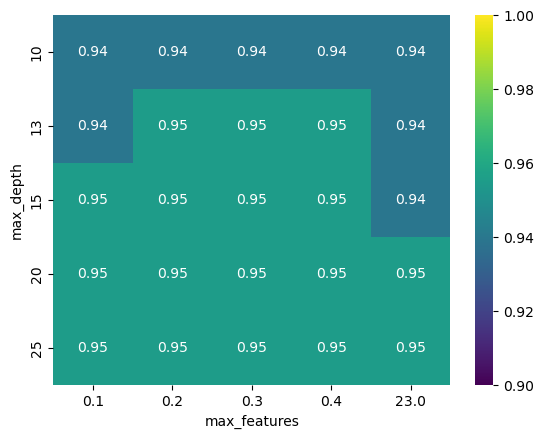

In [26]:
sns.heatmap(df_pivot, annot=True, cmap='viridis', vmin=0.9, vmax=1.0)
plt.savefig('hypers.png')